# Zillow Project  Workbook

-------------------------------------------------



## Import Menagerie

In [1]:
# Foundation
import pandas as pd
import numpy as np
from scipy import math

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns


# Metric and Modeling Tools
import sklearn.linear_model
import sklearn.feature_selection
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Custom
import wrangle_prep as wp
import explore as ep


# Required Data
df = wp.wrangle_zillow()
df.head(3)

Reading cleaned data from csv file...


,bedrooms,bathrooms,sqr_feet,tax_value,year_built,fips
0,4.0,2.0,3633.0,296425.0,2005,6037
1,3.0,2.0,1222.0,290492.0,1951,6037
2,3.0,2.5,1821.0,537949.0,2013,6059


In [2]:
# Make sure that year built is read as an object, not integer
df.year_built = df.year_built.astype(object)
df.fips = df.fips.astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355481 entries, 0 to 1355480
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bedrooms    1355481 non-null  float64
 1   bathrooms   1355481 non-null  float64
 2   sqr_feet    1355481 non-null  float64
 3   tax_value   1355481 non-null  float64
 4   year_built  1355481 non-null  object 
 5   fips        1355481 non-null  object 
dtypes: float64(4), object(2)
memory usage: 62.0+ MB


In [3]:
# Check for nulls
df.isnull().sum()

bedrooms      0
bathrooms     0
sqr_feet      0
tax_value     0
year_built    0
fips          0
dtype: int64

In [4]:
# Look into our target variable

df.tax_value.describe()
# There are some fairly big outliers in the top 25%

count    1.355481e+06
mean     3.475128e+05
std      1.987372e+05
min      1.000000e+00
25%      1.909800e+05
50%      3.222870e+05
75%      4.804860e+05
max      8.477320e+05
Name: tax_value, dtype: float64

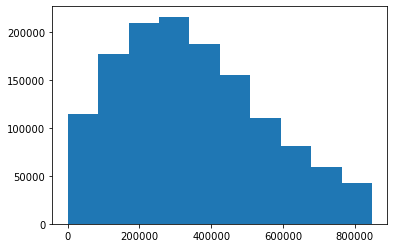

In [5]:
plt.hist(x='tax_value', data=df)
plt.show()

In [6]:
# Split our data for manipulation
train, validate, test = wp.split_data(df)

train <> (759068, 6)
validate <> (325316, 6)
test <> (271097, 6)


In [7]:
# Variables for constructing models

x_train = train.drop(columns=['tax_value'])
y_train = train.tax_value

x_validate = validate.drop(columns=['tax_value'])
y_validate = validate.tax_value

x_test = test.drop(columns=['tax_value'])
y_test = test.tax_value


In [8]:
# Scaled Versions of the data

# Make it
scaler = sklearn.preprocessing.MinMaxScaler()

# Fit it
scaler.fit(x_train)

# Use it
x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)


In [9]:
# Got my data and it's prepped, now lets explore a bit
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355481 entries, 0 to 1355480
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   bedrooms    1355481 non-null  float64
 1   bathrooms   1355481 non-null  float64
 2   sqr_feet    1355481 non-null  float64
 3   tax_value   1355481 non-null  float64
 4   year_built  1355481 non-null  object 
 5   fips        1355481 non-null  object 
dtypes: float64(4), object(2)
memory usage: 62.0+ MB


In [10]:
# Recursive Feature Selection
ep.rfe_feature_rankings(x_train_scaled, x_train, y_train, 1)

,Var,Rank
2,sqr_feet,1
1,bathrooms,2
0,bedrooms,3
3,year_built,4
4,fips,5


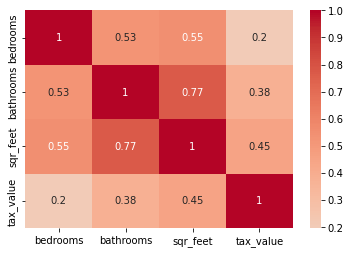

In [11]:
sns.heatmap(train.corr(), cmap='coolwarm', center=0, annot=True)
plt.show()


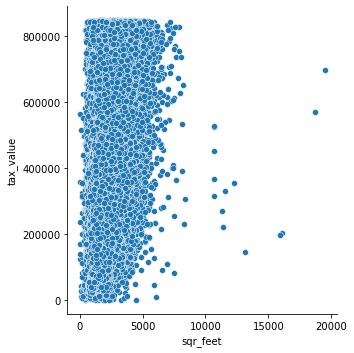

In [12]:
# Judging from the RFE ranking, gonna look into square footage more
sns.relplot(x='sqr_feet', y='tax_value', data=train)
plt.show()

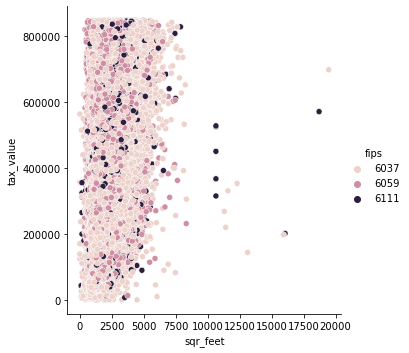

In [13]:
# Add hue to see if any catagories have impact
sns.relplot(x='sqr_feet', y='tax_value', data=train, hue='fips')
plt.show()

In [14]:
# fips details
train.fips.value_counts()

6037    429615
6059    251592
6111     77861
Name: fips, dtype: int64

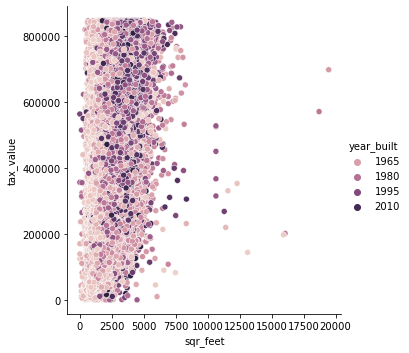

In [15]:
sns.relplot(x='sqr_feet', y='tax_value', data=train, hue='year_built')
plt.show()

In [16]:
# year_built details
train.year_built.value_counts()

1955    45802
1954    37272
1953    33629
1956    32996
1951    27716
        ...  
2012     1008
2009      850
2010      800
2011      782
2016       34
Name: year_built, Length: 66, dtype: int64

In [17]:
# Well that's and outlier that throws the graph
train.sqr_feet.describe()

count    759068.000000
mean       1820.759516
std         644.910118
min           1.000000
25%        1346.000000
50%        1680.000000
75%        2174.000000
max       19460.000000
Name: sqr_feet, dtype: float64

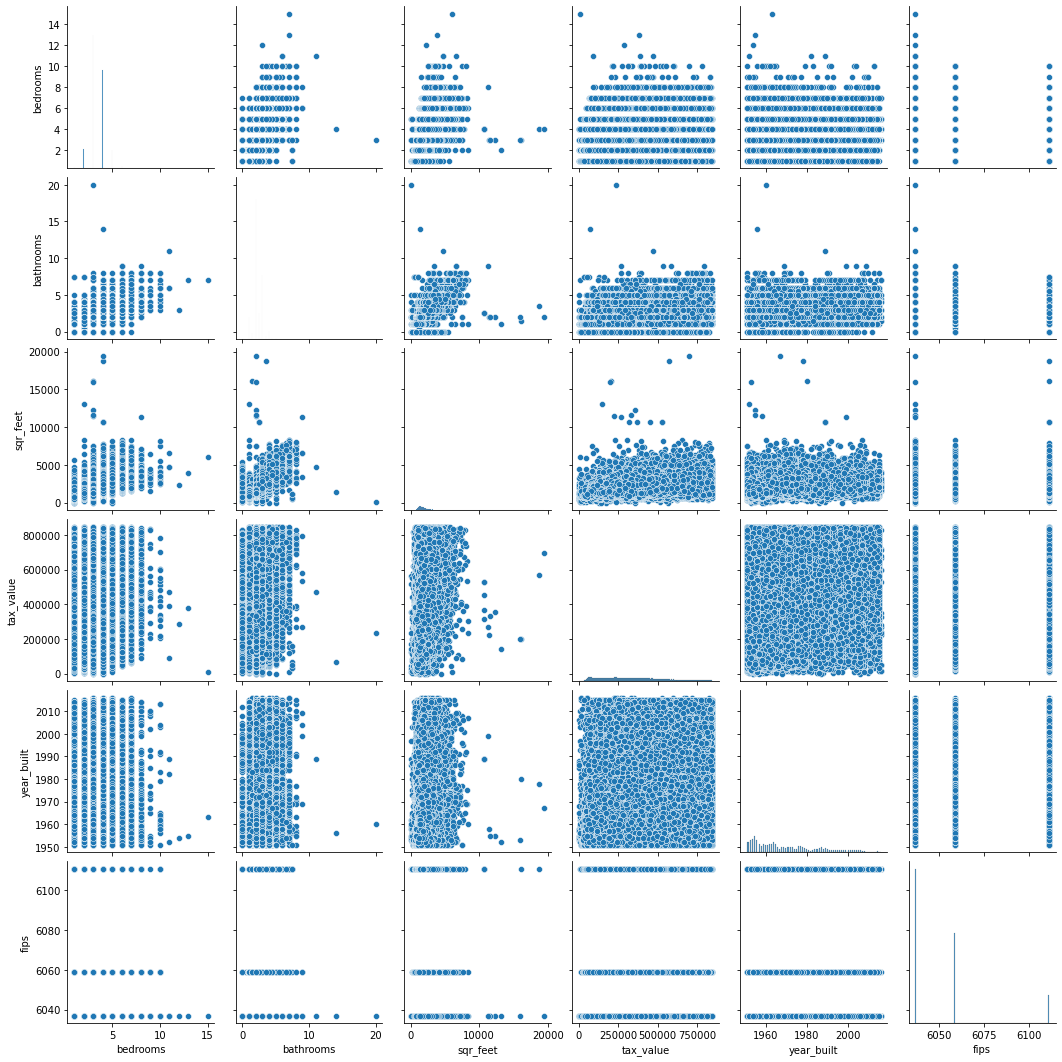

In [18]:
# look for any obvious relationships
sns.pairplot(train)
plt.show()

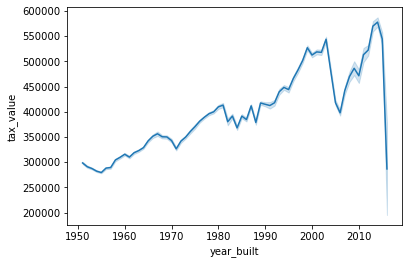

In [19]:
plt.figure()
sns.lineplot(train.year_built, train.tax_value)
plt.xlabel='Year Built'
plt.ylabel= 'Tax Value'
plt.title='Tax Value by Year Built'

plt.show()

In [20]:
sample = train.sample(10000)

<Figure size 432x288 with 0 Axes>

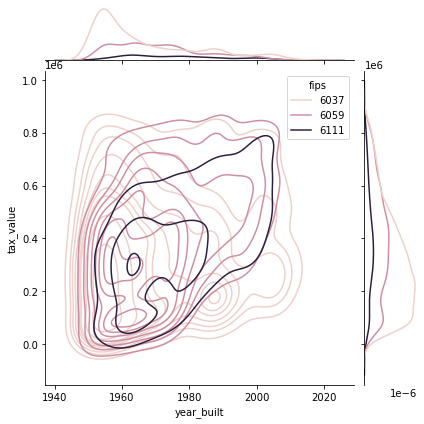

In [21]:
# Let's see what correlations exists between year built, the location of each house, and tax value

plt.figure()
sns.jointplot('year_built', 'tax_value', data=sample, hue='fips', kind='kde')
plt.xlabel='Year Built'
plt.ylabel= 'Tax Value'

plt.show()

In [22]:
# I feel after these  visualizations, a case could be made to remove homes built before 1950
# such an adjustment would better represent all 3 counties in our data (based on FIPS)

# Lets look just a bit more using statistical tests

# Let Us Model

In [23]:
# set up a df to compare our models with

# train
predictions = pd.DataFrame()
predictions['actual'] = train.tax_value
predictions['baseline'] = train.tax_value.median()

# validate
validate_predictions = pd.DataFrame()
validate_predictions['actual'] = validate.tax_value
validate_predictions['baseline'] = validate.tax_value.median()

In [24]:
predictions.head()

,actual,baseline
1246314,471141.0,322462.0
632828,416251.0,322462.0
708196,407927.0,322462.0
431350,323716.0,322462.0
258750,179451.0,322462.0


In [25]:
# Our 'Adv. Baseline' is just a simple linear regression based off sqr_feet

x_train_bl = x_train[['sqr_feet']]
x_validate_bl = x_validate[['sqr_feet']]

model = sklearn.linear_model.LinearRegression()

# train
model.fit(x_train_bl, y_train)
predictions['adv_baseline'] = model.predict(x_train_bl)

# validate
validate_predictions['adv_baseline_validate'] = model.predict(x_validate_bl)

# score
model.score(x_train_bl, y_train)

0.20494099024532597

In [26]:
# The math behind our advanced baseline model

m, b = model.coef_[0], model.intercept_

print(f'Tax Value = {m:.4f} x sqr_feet + {b:.4f}')

Tax Value = 139.5839 x sqr_feet + 93550.6824


In [27]:
predictions.head(1)

,actual,baseline,adv_baseline
1246314,471141.0,322462.0,405520.669795


In [28]:
# Now a multiple regression
model = sklearn.linear_model.LinearRegression()

# train
model.fit(x_train, y_train)
predictions['multi_regression'] = model.predict(x_train)

# validate
validate_predictions['multi_regression_validate'] = model.predict(x_validate)


predictions.head(3)

,actual,baseline,adv_baseline,multi_regression
1246314,471141.0,322462.0,405520.669795,428553.912380
632828,416251.0,322462.0,283384.768707,248849.158881
708196,407927.0,322462.0,297482.741290,278896.887160


In [29]:
model.score(x_train, y_train)

0.2254990052769058

In [31]:
# Multiple regression with RME
model = sklearn.linear_model.LinearRegression()
rfe = sklearn.feature_selection.RFE(model, n_features_to_select=4)

# train
rfe.fit(x_train, y_train)
x_train_rfe = rfe.transform(x_train)
model.fit(x_train_rfe, y_train)
predictions['multiple_rfe'] = model.predict(x_train_rfe)

# validate
x_validate_rfe = rfe.transform(x_validate)
validate_predictions['multiple_rfe_validate'] = model.predict(x_validate_rfe)

In [32]:
# K-NN
model = KNeighborsRegressor(n_neighbors=3)

# train
model.fit(x_train_scaled, y_train)
predictions['KNN(k=3)'] = model.predict(x_train)

# validate
validate_predictions['KNN(k=3)_validate'] = model.predict(x_validate)

In [33]:
predictions.head(3)

,actual,baseline,adv_baseline,multi_regression,multiple_rfe,KNN(k=3)
1246314,471141.0,322462.0,405520.669795,428553.912380,427000.130582,527064.0
632828,416251.0,322462.0,283384.768707,248849.158881,286123.751759,416941.0
708196,407927.0,322462.0,297482.741290,278896.887160,280452.588414,416941.0


In [34]:
# KNN (k=2)
model = KNeighborsRegressor(n_neighbors=2)

# train
model.fit(x_train_scaled, y_train)
predictions['KNN(k=2)'] = model.predict(x_train)

# validate
validate_predictions['KNN(k=2)_validate'] = model.predict(x_validate)

In [35]:
predictions.head(3)

,actual,baseline,adv_baseline,multi_regression,multiple_rfe,KNN(k=3),KNN(k=2)
1246314,471141.0,322462.0,405520.669795,428553.912380,427000.130582,527064.0,386417.5
632828,416251.0,322462.0,283384.768707,248849.158881,286123.751759,416941.0,409811.0
708196,407927.0,322462.0,297482.741290,278896.887160,280452.588414,416941.0,409811.0


In [36]:
# Polynomial (degree=2)
# keep it at 2 degree to prevent overfitting
poly = sklearn.preprocessing.PolynomialFeatures(degree=2, include_bias=False,  interaction_only=False)

# train
poly.fit(x_train)

x_train_poly = pd.DataFrame(poly.transform(x_train),
    columns=poly.get_feature_names(x_train.columns),
    index=train.index,
)

# validate
x_validate_poly = pd.DataFrame(poly.transform(x_validate),
    columns=poly.get_feature_names(x_validate.columns),
    index=validate.index,
)

x_train_poly.head(2)

,bedrooms,bathrooms,sqr_feet,year_built,fips,bedrooms^2,bedrooms bathrooms,bedrooms sqr_feet,bedrooms year_built,bedrooms fips,bathrooms^2,bathrooms sqr_feet,bathrooms year_built,bathrooms fips,sqr_feet^2,sqr_feet year_built,sqr_feet fips,year_built^2,year_built fips,fips^2
1246314,4.0,2.5,2235.0,2000.0,6059.0,16.0,10.0,8940.0,8000.0,24236.0,6.25,5587.5,5000.0,15147.5,4995225.0,4470000.0,13541865.0,4000000.0,12118000.0,36711481.0
632828,4.0,2.0,1360.0,1956.0,6037.0,16.0,8.0,5440.0,7824.0,24148.0,4.00,2720.0,3912.0,12074.0,1849600.0,2660160.0,8210320.0,3825936.0,11808372.0,36445369.0


In [37]:
# add it to our list

model = sklearn.linear_model.LinearRegression()

# train
model.fit(x_train_poly, y_train)
predictions['poly(degree=2)'] = model.predict(x_train_poly)

# validate
validate_predictions['poly(degree=2)_validate'] = model.predict(x_validate_poly)

In [38]:
predictions.head(2)

,actual,baseline,adv_baseline,multi_regression,multiple_rfe,KNN(k=3),KNN(k=2),poly(degree=2)
1246314,471141.0,322462.0,405520.669795,428553.912380,427000.130582,527064.0,386417.5,475979.476039
632828,416251.0,322462.0,283384.768707,248849.158881,286123.751759,416941.0,409811.0,253020.514469


In [39]:
# Compare how these models work on the train sample
pd.concat([
    predictions.apply(lambda col: r2_score(predictions.actual, col)).rename('r2'),
    predictions.apply(lambda col: mean_squared_error(predictions.actual, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(math.sqrt)
)

,r2,mse,rmse
actual,1.000000,0.000000e+00,0.000000
baseline,-0.016108,4.017719e+10,200442.480558
adv_baseline,0.204941,3.143684e+10,177304.377738
multi_regression,0.225499,3.062397e+10,174997.065814
multiple_rfe,0.170718,3.279002e+10,181080.147906
KNN(k=3),-0.385689,5.479049e+10,234073.682204
KNN(k=2),-0.302609,5.150550e+10,226948.232092
poly(degree=2),0.253407,2.952049e+10,171815.290427


In [40]:
# Compare how these models work on the validate sample
pd.concat([
    validate_predictions.apply(lambda col: r2_score(validate_predictions.actual, col)).rename('r2'),
    validate_predictions.apply(lambda col: mean_squared_error(validate_predictions.actual, col)).rename('mse'),
], axis=1).assign(
    rmse=lambda df: df.mse.apply(math.sqrt)
)

,r2,mse,rmse
actual,1.000000,0.000000e+00,0.000000
baseline,-0.015997,4.003649e+10,200091.206667
adv_baseline_validate,0.202878,3.141147e+10,177232.801013
multi_regression_validate,0.223230,3.060948e+10,174955.659504
multiple_rfe,0.169097,3.274265e+10,180949.309862
KNN(k=3)_validate,-0.390048,5.477638e+10,234043.547938
KNN(k=2)_validate,-0.302645,5.133217e+10,226566.031189
poly(degree=2)_validate,0.251142,2.950960e+10,171783.587787


In [ ]:
# looking at the model results I am excited to see each model perform fairly consistently

# The best model appears to be our polynomial